In [42]:
import re
import warnings
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time
import fasttext
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")

In [47]:
# Load the data
print("Loading data...")
path = "Data_set/best_200songs_perartist_nw.csv"
data = pd.read_csv(path)
print("Data loaded. Shape:", data.shape)

# Filter lyrics for Taylor Swift
data = data[data['artist'] == 'Taylor Swift']
print("Data filtered for Taylor Swift. Shape:", data.shape)

# Preprocess the lyrics
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

print("Preprocessing lyrics...")
data['clean_lyrics'] = data['clean_lyrics'].apply(preprocess_text)
print("Lyrics preprocessed. Sample data:\n", data['clean_lyrics'].head())

# Creating a corpus
print("Creating corpus...")
corpus = [lyrics.split() for lyrics in data['clean_lyrics']]
corpus_flat = [" ".join(sublist) for sublist in corpus]
with open("corpus.txt", "w") as file:
    file.write("\n".join(corpus_flat))
print("Corpus created. Total documents:", len(corpus))

# Train FastText model
print("Training FastText model...")
fasttext_model = fasttext.train_unsupervised('corpus.txt', model='skipgram', dim=100)
print("FastText model trained.")

# Creating vocabulary and mappings
print("Creating vocabulary and mappings...")
unique_words = fasttext_model.words
word_to_index = {word: idx for idx, word in enumerate(unique_words)}
index_to_word = {idx: word for word, idx in word_to_index.items()}
embedding_dim = fasttext_model.get_dimension()
print("Vocabulary size:", len(unique_words))

# Add a special token for unknown words
unk_token = '<UNK>'
word_to_index[unk_token] = len(word_to_index)
index_to_word[len(index_to_word)] = unk_token

Loading data...
Data loaded. Shape: (3800, 5)
Data filtered for Taylor Swift. Shape: (190, 5)
Preprocessing lyrics...
Lyrics preprocessed. Sample data:
 27    \n i walked through the door with you the air ...
31    \n vintage tee brand new phone \n high heels o...
48    \n we could leave the christmas lights up til ...
50    \n i m doing good i m on some new shit \n been...
65    \n i walked through the door with you the air ...
Name: clean_lyrics, dtype: object
Creating corpus...
Corpus created. Total documents: 190
Training FastText model...


Read 0M words
Number of words:  1169
Number of labels: 0
Progress:  68.4% words/sec/thread:  179068 lr:  0.015800 avg.loss:  2.609403 ETA:   0h 0m 0s

FastText model trained.
Creating vocabulary and mappings...
Vocabulary size: 1169


Progress: 100.0% words/sec/thread:  174802 lr:  0.000000 avg.loss:  2.624776 ETA:   0h 0m 0s


In [48]:
# Create an embedding matrix
print("Creating embedding matrix...")
embedding_matrix = np.zeros((len(unique_words) + 1, embedding_dim))
for word, idx in word_to_index.items():
    if word in fasttext_model:
        embedding_matrix[idx] = fasttext_model.get_word_vector(word)
    else:
        embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))

# Prepare sequences for training
sequence_length = 40
features = []
targets = []
print("Preparing sequences for training...")
for lyrics in corpus:
    for i in range(len(lyrics) - sequence_length):
        input_sequence = [word_to_index.get(word, word_to_index[unk_token]) for word in lyrics[i:i+sequence_length]]
        target_word = word_to_index.get(lyrics[i+sequence_length], word_to_index[unk_token])
        features.append(input_sequence)
        targets.append(target_word)

print("Total sequences prepared:", len(features))

# Convert to numpy arrays
features = np.array(features)
targets = np.array(targets)
print("Converted sequences to numpy arrays. Features shape:", features.shape, "Targets shape:", targets.shape)

# Split the dataset into train and test sets
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)
print("Data split. Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Convert to PyTorch tensors
print("Converting data to PyTorch tensors...")
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)
print("Data converted to tensors.")

Creating embedding matrix...
Preparing sequences for training...
Total sequences prepared: 66990
Converted sequences to numpy arrays. Features shape: (66990, 40) Targets shape: (66990,)
Splitting data into train and test sets...
Data split. Train shape: (53592, 40) Test shape: (13398, 40)
Converting data to PyTorch tensors...
Data converted to tensors.


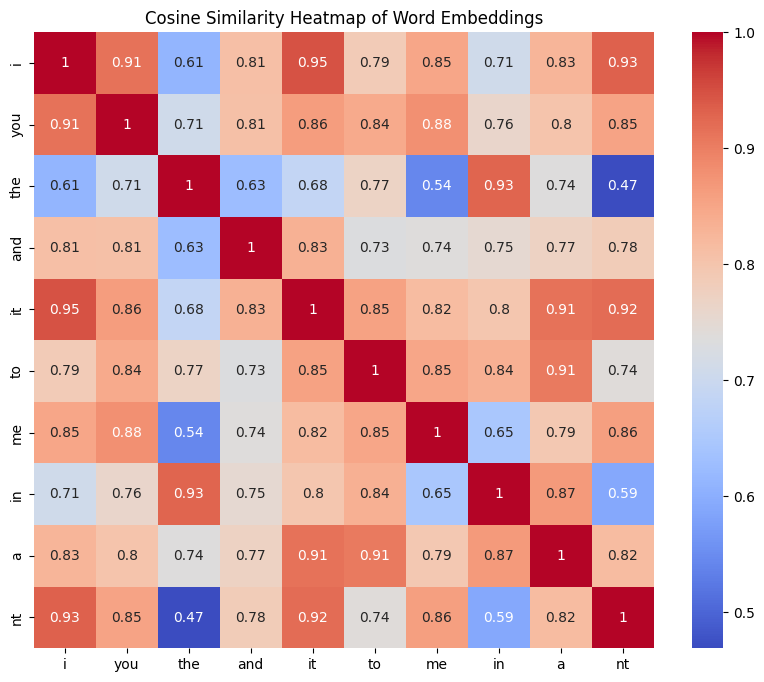

In [64]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def plot_heatmap(word_to_index, embedding_matrix, num_points=10):
    # Select the most frequent words
    words = list(word_to_index.keys())[:num_points]
    embeddings = embedding_matrix[:num_points]
    
    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings)
    
    # Create a DataFrame for the similarity matrix
    df_sim = pd.DataFrame(similarity_matrix, index=words, columns=words)
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_sim, annot=True, cmap='coolwarm')
    plt.title('Cosine Similarity Heatmap of Word Embeddings')
    plt.show()

# Plot the heatmap
plot_heatmap(word_to_index, embedding_matrix)


In [16]:
class LyricsDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

print("Creating DataLoader...")
train_dataset = LyricsDataset(X_train, y_train)
test_dataset = LyricsDataset(X_test, y_test)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
print("DataLoader created.")

class LyricsLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, embedding_matrix):
        super(LyricsLSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Hyperparameters
vocab_size = len(unique_words) + 1  # Add 1 for the UNK token
embed_size = embedding_dim
hidden_size = 256
num_layers = 2
num_epochs = 500
learning_rate = 0.001

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = LyricsLSTMModel(vocab_size, embed_size, hidden_size, num_layers, embedding_matrix).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Creating DataLoader...
DataLoader created.


In [17]:
# Train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                pbar.set_postfix({'loss': total_loss / (pbar.n + 1)})
                pbar.update(1)
        end_time = time.time()
        epoch_time = end_time - start_time
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Time: {epoch_time:.2f} sec')

print("Starting training...")
train_model(model, train_loader, criterion, optimizer, num_epochs)
print("Training completed.")

Python(12122) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Starting training...


Epoch 1/100: 100%|██████████| 210/210 [00:25<00:00,  8.19batch/s, loss=5.55]


Epoch [1/100], Loss: 5.5510, Time: 25.71 sec


Epoch 2/100: 100%|██████████| 210/210 [00:13<00:00, 15.62batch/s, loss=5.27]


Epoch [2/100], Loss: 5.2720, Time: 13.44 sec


Epoch 3/100: 100%|██████████| 210/210 [00:14<00:00, 14.75batch/s, loss=4.79]


Epoch [3/100], Loss: 4.7887, Time: 14.24 sec


Epoch 4/100: 100%|██████████| 210/210 [00:15<00:00, 13.98batch/s, loss=4.53]


Epoch [4/100], Loss: 4.5289, Time: 15.02 sec


Epoch 5/100: 100%|██████████| 210/210 [00:15<00:00, 13.39batch/s, loss=4.35]


Epoch [5/100], Loss: 4.3459, Time: 15.69 sec


Epoch 6/100: 100%|██████████| 210/210 [00:15<00:00, 13.86batch/s, loss=4.19]


Epoch [6/100], Loss: 4.1898, Time: 15.16 sec


Epoch 7/100: 100%|██████████| 210/210 [00:15<00:00, 13.31batch/s, loss=4.04]


Epoch [7/100], Loss: 4.0416, Time: 15.78 sec


Epoch 8/100: 100%|██████████| 210/210 [00:15<00:00, 13.89batch/s, loss=3.9] 


Epoch [8/100], Loss: 3.9045, Time: 15.12 sec


Epoch 9/100: 100%|██████████| 210/210 [00:15<00:00, 13.46batch/s, loss=3.78]


Epoch [9/100], Loss: 3.7811, Time: 15.61 sec


Epoch 10/100: 100%|██████████| 210/210 [00:15<00:00, 13.29batch/s, loss=3.66]


Epoch [10/100], Loss: 3.6622, Time: 15.81 sec


Epoch 11/100: 100%|██████████| 210/210 [00:15<00:00, 13.22batch/s, loss=3.55]


Epoch [11/100], Loss: 3.5531, Time: 15.89 sec


Epoch 12/100: 100%|██████████| 210/210 [00:16<00:00, 12.95batch/s, loss=3.45]


Epoch [12/100], Loss: 3.4452, Time: 16.22 sec


Epoch 13/100: 100%|██████████| 210/210 [00:15<00:00, 13.26batch/s, loss=3.35]


Epoch [13/100], Loss: 3.3494, Time: 15.84 sec


Epoch 14/100: 100%|██████████| 210/210 [00:15<00:00, 13.27batch/s, loss=3.26]


Epoch [14/100], Loss: 3.2562, Time: 15.83 sec


Epoch 15/100: 100%|██████████| 210/210 [00:15<00:00, 13.17batch/s, loss=3.17]


Epoch [15/100], Loss: 3.1657, Time: 15.95 sec


Epoch 16/100: 100%|██████████| 210/210 [00:16<00:00, 12.90batch/s, loss=3.09]


Epoch [16/100], Loss: 3.0851, Time: 16.28 sec


Epoch 17/100: 100%|██████████| 210/210 [00:17<00:00, 12.31batch/s, loss=3]   


Epoch [17/100], Loss: 3.0002, Time: 17.06 sec


Epoch 18/100: 100%|██████████| 210/210 [00:18<00:00, 11.58batch/s, loss=2.93]


Epoch [18/100], Loss: 2.9308, Time: 18.14 sec


Epoch 19/100: 100%|██████████| 210/210 [00:19<00:00, 11.02batch/s, loss=2.85]


Epoch [19/100], Loss: 2.8517, Time: 19.06 sec


Epoch 20/100: 100%|██████████| 210/210 [00:19<00:00, 11.04batch/s, loss=2.78]


Epoch [20/100], Loss: 2.7774, Time: 19.02 sec


Epoch 21/100: 100%|██████████| 210/210 [00:18<00:00, 11.26batch/s, loss=2.71]


Epoch [21/100], Loss: 2.7066, Time: 18.66 sec


Epoch 22/100: 100%|██████████| 210/210 [00:18<00:00, 11.31batch/s, loss=2.63]


Epoch [22/100], Loss: 2.6332, Time: 18.57 sec


Epoch 23/100: 100%|██████████| 210/210 [00:18<00:00, 11.30batch/s, loss=2.57]


Epoch [23/100], Loss: 2.5672, Time: 18.59 sec


Epoch 24/100: 100%|██████████| 210/210 [00:18<00:00, 11.31batch/s, loss=2.5] 


Epoch [24/100], Loss: 2.4994, Time: 18.58 sec


Epoch 25/100: 100%|██████████| 210/210 [00:18<00:00, 11.35batch/s, loss=2.44]


Epoch [25/100], Loss: 2.4374, Time: 18.51 sec


Epoch 26/100: 100%|██████████| 210/210 [00:18<00:00, 11.42batch/s, loss=2.37]


Epoch [26/100], Loss: 2.3741, Time: 18.39 sec


Epoch 27/100: 100%|██████████| 210/210 [00:18<00:00, 11.37batch/s, loss=2.31]


Epoch [27/100], Loss: 2.3103, Time: 18.47 sec


Epoch 28/100: 100%|██████████| 210/210 [00:18<00:00, 11.40batch/s, loss=2.25]


Epoch [28/100], Loss: 2.2511, Time: 18.43 sec


Epoch 29/100: 100%|██████████| 210/210 [00:19<00:00, 10.99batch/s, loss=2.19]


Epoch [29/100], Loss: 2.1906, Time: 19.11 sec


Epoch 30/100: 100%|██████████| 210/210 [00:19<00:00, 10.60batch/s, loss=2.14]


Epoch [30/100], Loss: 2.1350, Time: 19.81 sec


Epoch 31/100: 100%|██████████| 210/210 [00:19<00:00, 10.61batch/s, loss=2.08]


Epoch [31/100], Loss: 2.0782, Time: 19.79 sec


Epoch 32/100: 100%|██████████| 210/210 [00:20<00:00, 10.43batch/s, loss=2.02]


Epoch [32/100], Loss: 2.0226, Time: 20.13 sec


Epoch 33/100: 100%|██████████| 210/210 [00:19<00:00, 10.57batch/s, loss=1.97]


Epoch [33/100], Loss: 1.9675, Time: 19.87 sec


Epoch 34/100: 100%|██████████| 210/210 [00:20<00:00, 10.46batch/s, loss=1.91]


Epoch [34/100], Loss: 1.9136, Time: 20.09 sec


Epoch 35/100: 100%|██████████| 210/210 [00:19<00:00, 10.71batch/s, loss=1.86]


Epoch [35/100], Loss: 1.8640, Time: 19.61 sec


Epoch 36/100: 100%|██████████| 210/210 [00:19<00:00, 10.51batch/s, loss=1.81]


Epoch [36/100], Loss: 1.8105, Time: 19.98 sec


Epoch 37/100: 100%|██████████| 210/210 [00:19<00:00, 11.00batch/s, loss=1.76]


Epoch [37/100], Loss: 1.7589, Time: 19.09 sec


Epoch 38/100: 100%|██████████| 210/210 [00:19<00:00, 11.03batch/s, loss=1.71]


Epoch [38/100], Loss: 1.7115, Time: 19.05 sec


Epoch 39/100: 100%|██████████| 210/210 [00:19<00:00, 10.57batch/s, loss=1.66]


Epoch [39/100], Loss: 1.6622, Time: 19.86 sec


Epoch 40/100: 100%|██████████| 210/210 [00:20<00:00, 10.34batch/s, loss=1.61]


Epoch [40/100], Loss: 1.6143, Time: 20.31 sec


Epoch 41/100: 100%|██████████| 210/210 [00:20<00:00, 10.38batch/s, loss=1.57]


Epoch [41/100], Loss: 1.5668, Time: 20.24 sec


Epoch 42/100: 100%|██████████| 210/210 [00:20<00:00, 10.20batch/s, loss=1.52]


Epoch [42/100], Loss: 1.5209, Time: 20.59 sec


Epoch 43/100: 100%|██████████| 210/210 [00:20<00:00, 10.24batch/s, loss=1.47]


Epoch [43/100], Loss: 1.4749, Time: 20.50 sec


Epoch 44/100: 100%|██████████| 210/210 [00:19<00:00, 10.53batch/s, loss=1.43]


Epoch [44/100], Loss: 1.4313, Time: 19.94 sec


Epoch 45/100: 100%|██████████| 210/210 [00:19<00:00, 10.71batch/s, loss=1.39]


Epoch [45/100], Loss: 1.3895, Time: 19.62 sec


Epoch 46/100: 100%|██████████| 210/210 [00:19<00:00, 10.83batch/s, loss=1.34]


Epoch [46/100], Loss: 1.3443, Time: 19.39 sec


Epoch 47/100: 100%|██████████| 210/210 [00:19<00:00, 10.97batch/s, loss=1.3] 


Epoch [47/100], Loss: 1.3044, Time: 19.15 sec


Epoch 48/100: 100%|██████████| 210/210 [00:19<00:00, 10.96batch/s, loss=1.26]


Epoch [48/100], Loss: 1.2608, Time: 19.17 sec


Epoch 49/100: 100%|██████████| 210/210 [00:19<00:00, 10.99batch/s, loss=1.22]


Epoch [49/100], Loss: 1.2204, Time: 19.12 sec


Epoch 50/100: 100%|██████████| 210/210 [00:19<00:00, 11.03batch/s, loss=1.18]


Epoch [50/100], Loss: 1.1823, Time: 19.04 sec


Epoch 51/100: 100%|██████████| 210/210 [00:18<00:00, 11.10batch/s, loss=1.15]


Epoch [51/100], Loss: 1.1462, Time: 18.92 sec


Epoch 52/100: 100%|██████████| 210/210 [00:18<00:00, 11.16batch/s, loss=1.11]


Epoch [52/100], Loss: 1.1071, Time: 18.82 sec


Epoch 53/100: 100%|██████████| 210/210 [00:18<00:00, 11.12batch/s, loss=1.07]


Epoch [53/100], Loss: 1.0699, Time: 18.88 sec


Epoch 54/100: 100%|██████████| 210/210 [00:18<00:00, 11.25batch/s, loss=1.03]


Epoch [54/100], Loss: 1.0340, Time: 18.67 sec


Epoch 55/100: 100%|██████████| 210/210 [00:18<00:00, 11.23batch/s, loss=0.997]


Epoch [55/100], Loss: 0.9966, Time: 18.70 sec


Epoch 56/100: 100%|██████████| 210/210 [00:18<00:00, 11.09batch/s, loss=0.964]


Epoch [56/100], Loss: 0.9644, Time: 18.94 sec


Epoch 57/100: 100%|██████████| 210/210 [00:18<00:00, 11.11batch/s, loss=0.931]


Epoch [57/100], Loss: 0.9305, Time: 18.91 sec


Epoch 58/100: 100%|██████████| 210/210 [00:19<00:00, 10.76batch/s, loss=0.896]


Epoch [58/100], Loss: 0.8956, Time: 19.52 sec


Epoch 59/100: 100%|██████████| 210/210 [00:19<00:00, 10.56batch/s, loss=0.866]


Epoch [59/100], Loss: 0.8655, Time: 19.90 sec


Epoch 60/100: 100%|██████████| 210/210 [00:20<00:00, 10.39batch/s, loss=0.834]


Epoch [60/100], Loss: 0.8343, Time: 20.22 sec


Epoch 61/100: 100%|██████████| 210/210 [00:20<00:00, 10.50batch/s, loss=0.802]


Epoch [61/100], Loss: 0.8020, Time: 20.01 sec


Epoch 62/100: 100%|██████████| 210/210 [00:20<00:00, 10.33batch/s, loss=0.771]


Epoch [62/100], Loss: 0.7714, Time: 20.32 sec


Epoch 63/100: 100%|██████████| 210/210 [00:20<00:00, 10.24batch/s, loss=0.741]


Epoch [63/100], Loss: 0.7414, Time: 20.51 sec


Epoch 64/100: 100%|██████████| 210/210 [00:20<00:00, 10.22batch/s, loss=0.714]


Epoch [64/100], Loss: 0.7135, Time: 20.56 sec


Epoch 65/100: 100%|██████████| 210/210 [00:21<00:00,  9.97batch/s, loss=0.688]


Epoch [65/100], Loss: 0.6883, Time: 21.06 sec


Epoch 66/100: 100%|██████████| 210/210 [00:20<00:00, 10.32batch/s, loss=0.658]


Epoch [66/100], Loss: 0.6585, Time: 20.35 sec


Epoch 67/100: 100%|██████████| 210/210 [00:19<00:00, 10.63batch/s, loss=0.633]


Epoch [67/100], Loss: 0.6333, Time: 19.75 sec


Epoch 68/100: 100%|██████████| 210/210 [00:19<00:00, 10.72batch/s, loss=0.606]


Epoch [68/100], Loss: 0.6064, Time: 19.59 sec


Epoch 69/100: 100%|██████████| 210/210 [00:19<00:00, 10.72batch/s, loss=0.587]


Epoch [69/100], Loss: 0.5869, Time: 19.59 sec


Epoch 70/100: 100%|██████████| 210/210 [00:19<00:00, 10.79batch/s, loss=0.558]


Epoch [70/100], Loss: 0.5579, Time: 19.47 sec


Epoch 71/100: 100%|██████████| 210/210 [00:19<00:00, 10.65batch/s, loss=0.534]


Epoch [71/100], Loss: 0.5337, Time: 19.72 sec


Epoch 72/100: 100%|██████████| 210/210 [00:19<00:00, 10.66batch/s, loss=0.51] 


Epoch [72/100], Loss: 0.5103, Time: 19.71 sec


Epoch 73/100: 100%|██████████| 210/210 [00:20<00:00, 10.43batch/s, loss=0.493]


Epoch [73/100], Loss: 0.4926, Time: 20.13 sec


Epoch 74/100: 100%|██████████| 210/210 [00:20<00:00, 10.37batch/s, loss=0.468]


Epoch [74/100], Loss: 0.4685, Time: 20.25 sec


Epoch 75/100: 100%|██████████| 210/210 [00:20<00:00, 10.29batch/s, loss=0.45] 


Epoch [75/100], Loss: 0.4499, Time: 20.41 sec


Epoch 76/100: 100%|██████████| 210/210 [00:20<00:00, 10.28batch/s, loss=0.43] 


Epoch [76/100], Loss: 0.4301, Time: 20.43 sec


Epoch 77/100: 100%|██████████| 210/210 [00:20<00:00, 10.19batch/s, loss=0.412]


Epoch [77/100], Loss: 0.4124, Time: 20.62 sec


Epoch 78/100: 100%|██████████| 210/210 [00:20<00:00, 10.29batch/s, loss=0.385]


Epoch [78/100], Loss: 0.3848, Time: 20.42 sec


Epoch 79/100: 100%|██████████| 210/210 [00:20<00:00, 10.32batch/s, loss=0.369]


Epoch [79/100], Loss: 0.3694, Time: 20.35 sec


Epoch 80/100: 100%|██████████| 210/210 [00:20<00:00, 10.34batch/s, loss=0.353]


Epoch [80/100], Loss: 0.3531, Time: 20.32 sec


Epoch 81/100: 100%|██████████| 210/210 [00:20<00:00, 10.42batch/s, loss=0.34] 


Epoch [81/100], Loss: 0.3403, Time: 20.15 sec


Epoch 82/100: 100%|██████████| 210/210 [00:20<00:00, 10.45batch/s, loss=0.324]


Epoch [82/100], Loss: 0.3243, Time: 20.10 sec


Epoch 83/100: 100%|██████████| 210/210 [00:20<00:00, 10.42batch/s, loss=0.305]


Epoch [83/100], Loss: 0.3048, Time: 20.16 sec


Epoch 84/100: 100%|██████████| 210/210 [00:20<00:00, 10.39batch/s, loss=0.29] 


Epoch [84/100], Loss: 0.2903, Time: 20.21 sec


Epoch 85/100: 100%|██████████| 210/210 [00:20<00:00, 10.21batch/s, loss=0.289]


Epoch [85/100], Loss: 0.2893, Time: 20.58 sec


Epoch 86/100: 100%|██████████| 210/210 [00:20<00:00, 10.07batch/s, loss=0.261]


Epoch [86/100], Loss: 0.2611, Time: 20.87 sec


Epoch 87/100: 100%|██████████| 210/210 [00:21<00:00, 10.00batch/s, loss=0.245]


Epoch [87/100], Loss: 0.2454, Time: 21.01 sec


Epoch 88/100: 100%|██████████| 210/210 [00:21<00:00,  9.77batch/s, loss=0.23] 


Epoch [88/100], Loss: 0.2296, Time: 21.49 sec


Epoch 89/100: 100%|██████████| 210/210 [00:21<00:00,  9.63batch/s, loss=0.223]


Epoch [89/100], Loss: 0.2230, Time: 21.81 sec


Epoch 90/100: 100%|██████████| 210/210 [00:21<00:00,  9.71batch/s, loss=0.22] 


Epoch [90/100], Loss: 0.2203, Time: 21.64 sec


Epoch 91/100: 100%|██████████| 210/210 [00:21<00:00,  9.90batch/s, loss=0.218]


Epoch [91/100], Loss: 0.2180, Time: 21.22 sec


Epoch 92/100: 100%|██████████| 210/210 [00:20<00:00, 10.15batch/s, loss=0.193]


Epoch [92/100], Loss: 0.1926, Time: 20.70 sec


Epoch 93/100: 100%|██████████| 210/210 [00:20<00:00, 10.33batch/s, loss=0.18] 


Epoch [93/100], Loss: 0.1796, Time: 20.34 sec


Epoch 94/100: 100%|██████████| 210/210 [00:20<00:00, 10.27batch/s, loss=0.169]


Epoch [94/100], Loss: 0.1688, Time: 20.44 sec


Epoch 95/100: 100%|██████████| 210/210 [00:20<00:00, 10.31batch/s, loss=0.162]


Epoch [95/100], Loss: 0.1623, Time: 20.38 sec


Epoch 96/100: 100%|██████████| 210/210 [00:20<00:00, 10.27batch/s, loss=0.172]


Epoch [96/100], Loss: 0.1719, Time: 20.45 sec


Epoch 97/100: 100%|██████████| 210/210 [00:20<00:00, 10.25batch/s, loss=0.179]


Epoch [97/100], Loss: 0.1795, Time: 20.50 sec


Epoch 98/100: 100%|██████████| 210/210 [00:20<00:00, 10.40batch/s, loss=0.155]


Epoch [98/100], Loss: 0.1547, Time: 20.20 sec


Epoch 99/100: 100%|██████████| 210/210 [00:22<00:00,  9.33batch/s, loss=0.134]


Epoch [99/100], Loss: 0.1336, Time: 22.51 sec


Epoch 100/100: 100%|██████████| 210/210 [00:22<00:00,  9.26batch/s, loss=0.119]

Epoch [100/100], Loss: 0.1190, Time: 22.69 sec
Training completed.


In [75]:
# Function to generate lyrics with temperature sampling and formatting
def generate_lyrics(model, start_text, length, temperature=20):
    model.eval()
    generated = start_text
    input_sequence = [word_to_index.get(word, word_to_index[unk_token]) for word in start_text.split()]
    generated_words = start_text.split()
    for _ in range(length):
        input_tensor = torch.tensor(input_sequence).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
        output = output.squeeze().div(temperature).exp()
        word_weights = output.cpu().numpy()
        next_word_idx = np.random.choice(len(word_weights), p=word_weights/word_weights.sum())
        next_word = index_to_word[next_word_idx]
        generated_words.append(next_word)
        input_sequence.append(next_word_idx)
        input_sequence = input_sequence[1:]

    return generated_words

In [76]:
# Function to format lyrics into verses and choruses
def format_lyrics(generated_words):
    formatted_lyrics = "\nVerse 1:\n"
    line_length = 0
    verse_count = 1
    chorus_count = 1
    is_chorus = False

    for word in generated_words:
        formatted_lyrics += word + " "
        line_length += 1
        if line_length >= 7:
            formatted_lyrics = formatted_lyrics.strip() + "\n"
            line_length = 0
            if is_chorus:
                chorus_count += 1
                if chorus_count > 4:
                    is_chorus = False
                    chorus_count = 1
                    verse_count += 1
                    formatted_lyrics += f"\nVerse {verse_count}:\n"
            else:
                verse_count += 1
                if verse_count > 4:
                    is_chorus = True
                    verse_count = 1
                    formatted_lyrics += f"\nChorus:\n"

    return formatted_lyrics.strip()

# Example usage for lyrics generation
start_text = "Once upon a time"
generated_words = generate_lyrics(model, start_text, 72, temperature=1.2)
formatted_lyrics = format_lyrics(generated_words)
print("Generated lyrics:\n", formatted_lyrics)

Generated lyrics:
 Verse 1:
Once upon a time with give front
true to keep in look <UNK> wanna
tell how front and give would could
ve only never get guess are never

Chorus:
christmas some jeans oh and sometimes <UNK>
on minds cause could shake call you
<UNK> with to fight love but ah
want you and you could try but

Verse 2:
your i want you want what if
that two me got you like fighting
on that you tell listen girls
